In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense,Activation
import datetime
from sklearn.model_selection import train_test_split


In [3]:
#삼성전자 최근 5년간 주식 데이터를 가져왔다.
data = pd.read_csv("./data/005930.KS.csv")
print(data.shape)
data.head()

(1226, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-12,22960.0,23320.0,22880.0,22920.0,1100.948608,10314150.0
1,2016-01-13,23060.0,23180.0,22960.0,22960.0,1102.869751,7165800.0
2,2016-01-14,22620.0,22840.0,22620.0,22760.0,1093.263062,10451100.0
3,2016-01-15,22800.0,23040.0,22480.0,22640.0,1087.498779,10473200.0
4,2016-01-18,21760.0,22660.0,21760.0,22520.0,1081.734741,16010700.0


In [4]:
# 결측치를 제거했다.
# 역시, 데이터 전처리가 제일 중요하다.
data = data.dropna()
data.shape

(1221, 7)

In [5]:
#high_price와 low_pirce의 평균을 가지고 예측

high_prices = data["High"].values
low_prices = data["Low"].values
mid_prices = (high_prices + low_prices) /2

# LSTM 만들기

최근 50일 데이터를 보고, 내일을 예측한다.

예를 들어,

1 ~ 50을 보고 51 예측 // 

2 ~ 51을 보고 52 예측

In [6]:
seq_len = 50 #이것을 윈도우 크기라고 이해할 수 있다.
seqence_length = seq_len + 1 # 51개를 저장해야지! (50개는 train, 1개는 예측)

result = []
for index in range(len(mid_prices) - seqence_length):
    result.append(mid_prices[index:index+seqence_length]) # 이렇게 하면 끝까지 다 들어간다.
    


In [117]:
# 정규화

# 1170*51 만큼의 데이터가 존재.
# 각 데이터의 0번째 인덱스를 '0'으로 잡고, 비율을 만든다.
# 자기 자신으로 나누고, 1을 하면 0이 된다.

normalized_data = []
for window in result:
    normalized_data.append((window / window[0]) -1)

result = np.array(normalized_data)


<ipython-input-117-a07fff3e6f47>:9: RuntimeWarning: divide by zero encountered in true_divide
  normalized_data.append((window / window[0]) -1)
<ipython-input-117-a07fff3e6f47>:9: RuntimeWarning: invalid value encountered in true_divide
  normalized_data.append((window / window[0]) -1)


(1170, 51)

In [28]:
# train set과 test을 나누자.
from sklearn.model_selection import train_test_split
X = result[:,:-1]
y = result[:,-1]

# shuffle을 하면 안됌 --> 시계열이니까
x_train, x_test,y_train, y_test = train_test_split(X,y, random_state = 42, shuffle = False, test_size = 0.1)

#shape을 3차원으로 reshape (데이터의 개수, window의 크기, 시간축(?) )인것으로 추정된다.
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#shape 확인
print("x_train.shape = {}, x_test.shape = {}".format(x_train.shape, x_test.shape))


x_train.shape = (1053, 50, 1), x_test.shape = (117, 50, 1)


In [29]:
print("y_train.shape = {}, y_test.shape = {}".format(y_train.shape, y_test.shape))

y_train.shape = (1053,), y_test.shape = (117,)


# Build a model

In [30]:
model = Sequential()

# 첫번째 유닛 수 --> 50이라는 input은 이미 우리가 처음 시작할때, 정해줌
model.add(LSTM(50,
               return_sequences = True, 
               input_shape = (50,1)))

# 두번째 유닛 수 --> 64는 조정가능함
model.add(LSTM(64,
               return_sequences = False))

# 아웃풋 --> 50개의 데이터를 보고, 다음날 하루를 예측하므로, 1이 등장.
model.add(Dense(1, activation = 'linear'))



model.compile(loss = "mse", optimizer = "rmsprop")


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [31]:
#학습진행하기
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=5)

Epoch 1/5
106/106 [==============================] - 6s 36ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 2/5
106/106 [==============================] - 3s 31ms/step - loss: 9.6394e-04 - val_loss: 0.0019
Epoch 3/5
106/106 [==============================] - 3s 33ms/step - loss: 6.1664e-04 - val_loss: 0.0014
Epoch 4/5
106/106 [==============================] - 3s 29ms/step - loss: 4.4320e-04 - val_loss: 8.7175e-04
Epoch 5/5
106/106 [==============================] - 3s 32ms/step - loss: 3.9632e-04 - val_loss: 4.3124e-04


In [32]:
#예측
pred = model.predict(x_test)

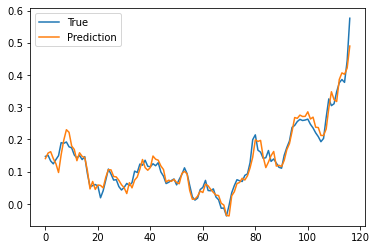

<Figure size 1440x360 with 0 Axes>

In [33]:
#그래프 그리기
import matplotlib.pyplot as plt
fig = plt.figure(facecolor = "white")
ax = fig.add_subplot(111)

plt.figure(figsize = (20,5))
ax.plot(y_test, label = 'True')
ax.plot(pred, label = 'Prediction')
ax.legend()
plt.show()

In [46]:
#활용하기

(117, 50, 1)

In [110]:
graph = [] # 앞으로 50일 예측

temp = x_test[-1].reshape(1,-1,1) # ~ 1/12 (이전 50일)
cnt = 0 #50개 카운트

while cnt < 50:
    answer = model.predict(temp) #예측
    graph.append(float(answer.squeeze())) #저장
    temp2 = temp.squeeze(axis = 0) # shape을 맞춰주기 위해
    temp = np.concatenate([temp2[1:],answer], axis = 0)
    temp = temp.reshape(1,-1,1)

    cnt += 1

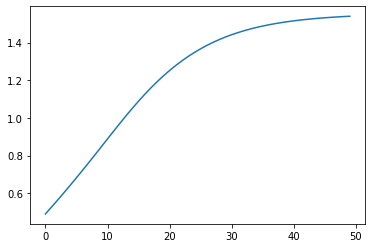

In [118]:
plt.plot(graph)
plt.show()

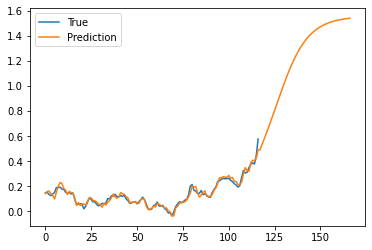

<Figure size 1440x360 with 0 Axes>

In [116]:
fig = plt.figure(facecolor = "white")
ax = fig.add_subplot(111)

plt.figure(figsize = (20,5))
ax.plot(y_test, label = 'True')
ax.plot(total, label = 'Prediction')
ax.legend()
plt.show()

### 결론: 삼성전자의 주가는 근 50일 동안 고공행진일 예정이고,
### 그나마 유의미한 결과(?) 20~30일 뒤 즈음, 성장세가 완만해질 예정


1) 데이터의 전치리가 중요: drop.na

2) input 데이터의 크기가 3차원이여야 한다.

3) 